Correlation Analysis

Examples of guiding questions: 

- How many qualitative and quantitative variables are there? What are appropiate visuals for quantitative vs qualitative data? What are appropiate measures for correlations when dealing with qualitative and quantitative variables?

- What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?

- How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?

In [15]:
#Import the clean data file
import pandas as pd
import numpy as np
import seaborn as sns

file_path = "cleaned_properties.csv"
with open(file_path, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    sep = ';' if ';' in first_line else ','
df = pd.read_csv(file_path, sep=sep, low_memory=False)

In [ ]:
# Capping of data and log-transformations of highly skewed variables

df_before = df.copy() #Keeping a copy of data before capping
cap_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm', 'nbr_bedrooms', 'nbr_frontages']
lower_cap = 0.01
upper_cap = 0.99
for var in cap_vars:
    lower = df[var].quantile(lower_cap)
    upper = df[var].quantile(upper_cap)
    df[var] = np.where(df[var] < lower, lower,
                       np.where(df[var] > upper, upper, df[var]))

# Initiating the log-transfiormations (nbr_bedrooms and nbr_frontages were normalized only by the capping so no need for log-trandformation)
log_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm']
for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])
df[[f'{v}_log' for v in log_vars]].skew()


price_log               0.633032
surface_land_sqm_log   -1.389089
total_area_sqm_log      0.359023
garden_sqm_log          1.949138
terrace_sqm_log         0.382170
dtype: float64

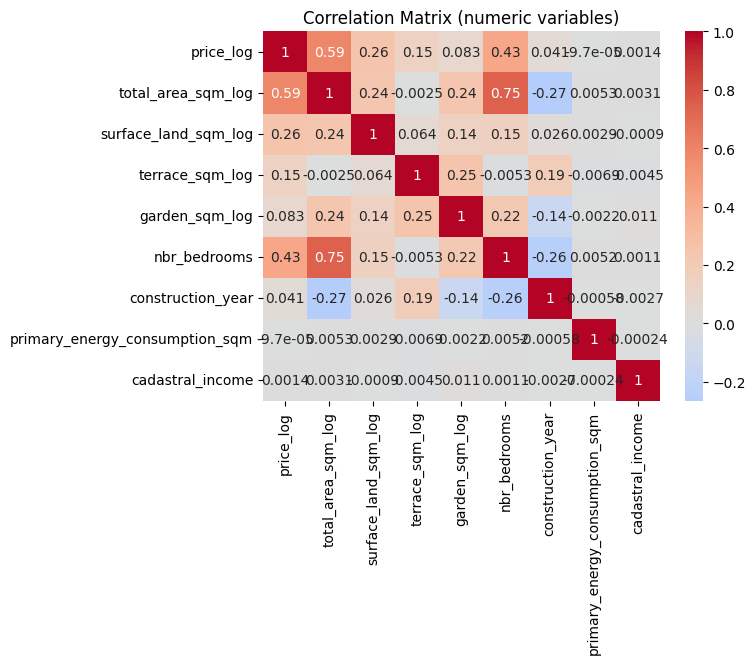

In [17]:
# Corr between price and continuous (numeric) variables (Correlation Matrix) - Pearson's corr
import matplotlib.pyplot as plt

#Numeric vars
num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm','cadastral_income']

corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (numeric variables)")
plt.show()

In [18]:
# which regions/ provinces have the highest median prices

df.groupby('region')['price'].median().sort_values(ascending=False)

region
Brussels-Capital    380000.0
Flanders            351100.0
Wallonia            270000.0
Name: price, dtype: float64

In [19]:
# Price_log vs Numeric/log-tranformed variables - Pearson's 
# Approach: for the moment Nans are ignored by pandas, however,to decide whether we will put median to missing values in numerical
'''
Interpretation
Pearson r:
0.0–0.3 -> weak correlation
0.3–0.5 -> moderate correlation
0.5–0.9 -> strong correlation
0.9+ -> very strong correlation
p-value:
Small p (<0.05) -> correlation is statistically significant
Large p (≥0.05) -> not significant; could be noise
'''
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm', 'cadastral_income','nbr_frontages']

rows = []

for col2 in num_cols:
    # Skip price_log vs price_log if you want
    if col2 == 'price_log':
        continue
    
    # Extract numeric series
    x = pd.to_numeric(df['price_log'], errors='coerce')
    y = pd.to_numeric(df[col2], errors='coerce')
    
    # Pairwise valid values
    mask = x.notna() & y.notna()
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Handle constant columns or too few observations
    if len(x_clean) < 2 or x_clean.nunique() <= 1 or y_clean.nunique() <= 1:
        r, p = np.nan, np.nan
    else:
        r, p = pearsonr(x_clean, y_clean)
    
    rows.append({'Variable 1': 'price_log',
                 'Variable 2': col2,
                 'Pearson r': r,
                 'p-value': p})

# Convert to DataFrame and sort by absolute correlation
price_corr_table = pd.DataFrame(rows)
price_corr_table['abs_r'] = price_corr_table['Pearson r'].abs()
price_corr_table = price_corr_table.sort_values(by='abs_r', ascending=False).drop(columns='abs_r')

price_corr_table


# When we run those correlations with -1 and missing_flag, the coefficients are lower than the results where we keep NANs;
# Also, the order of variables change. Below is the output of NAN kept. 
# 
# NANs are kept in the data set and ignored by pandas:
#  	Variable 1	Variable 2	Pearson r	p-value
#0	price_log	total_area_sqm_log	0.592684	0.000000e+00
#4	price_log	nbr_bedrooms	0.434120	0.000000e+00
#1	price_log	surface_land_sqm_log	0.257446	0.000000e+00
#8	price_log	nbr_frontages	0.234163	0.000000e+00
#2	price_log	terrace_sqm_log	0.149055	1.134266e-306
#3	price_log	garden_sqm_log	0.083078	2.603757e-111
#5	price_log	construction_year	0.041244	2.497824e-17
#7	price_log	cadastral_income	0.001438	8.016331e-01
#6	price_log	primary_energy_consumption_sqm	-0.000097	9.829247e-01

,Variable 1,Variable 2,Pearson r,p-value
0,price_log,total_area_sqm_log,0.592684,0.000000e+00
4,price_log,nbr_bedrooms,0.434120,0.000000e+00
1,price_log,surface_land_sqm_log,0.257446,0.000000e+00
8,price_log,nbr_frontages,0.234163,0.000000e+00
2,price_log,terrace_sqm_log,0.149055,1.135497e-306
3,price_log,garden_sqm_log,0.083078,2.603751e-111
5,price_log,construction_year,0.041244,2.498748e-17
7,price_log,cadastral_income,0.001438,8.016324e-01
6,price_log,primary_energy_consumption_sqm,-0.000097,9.829238e-01


In [36]:
#Checking the categorical variables for unique values
#fl_swimming_pool causing error in ANOVA due to single unique value

for var in cat_vars:
    print(var, df[var].nunique())

property_type 2
subproperty_type 23
region 3
province 11
epc 5
heating_type 8
equipped_kitchen 9
state_building 7


In [21]:
# Price vs categorical variables - ANOVA
# F-statistic and p-value indicate whether the categorical variables have significant effects on price
# F- statistic: Measures how large the price differences are between categories relative to within-category variation (higher F -> stronger signal -> the variable kilely affects price).
# p-value: probability these differences happened by chance
# Eta sqaured: tells the strength of the categorical effect; 0.01-small, 0.06 -medium, 0.14- large 
# Notes: locality is left out due to granularity; zip_code, latitude and longitude better used only for clustering and mapping


import statsmodels.api as sm
from statsmodels.formula.api import ols

# Example for variable property_type
model = ols('price_log ~ C(property_type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Iterating over all categorical variables; 
cat_vars = ['property_type', 'subproperty_type', 'region', 'province','epc', 'heating_type','equipped_kitchen','state_building']
anova_results = []

for var in cat_vars:
    model = ols(f'price_log ~ C({var})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    ss_effect = anova_table['sum_sq'].iloc[0] # effect sum of squares (SS)
    ss_resid  = anova_table['sum_sq'].iloc[1] # residual SS
    ss_total  = ss_effect + ss_resid # total SS
    
    eta_sq = ss_effect / ss_total# eta squared
    
    F = anova_table['F'].iloc[0]
    p = anova_table['PR(>F)'].iloc[0]
    anova_results.append({'Variable': var,'F-statistic': F,'p-value': p,'Eta_squared': eta_sq})

anova_df = pd.DataFrame(anova_results).sort_values(by='Eta_squared', ascending=False)
anova_df
display(anova_df)

#Interpretation of Results: 

# Results do not vary between data sets where we keep NAN and where we replace it with -1 and missing_flag;

#   Subproperty Type — strongest predictor 
#       The detailed property subtype captures meaningful differences between villas, duplexes, penthouses, and other categories.
#       These segments have distinct market behaviours, explaining a large share of price variation.
#   Province — strong geographic effect
#       Provincial markets differ sharply, reflecting local demand dynamics.
#   Equipped Kitchen — strong structural/quality signal 
#       Beyond appliances, this variable proxies renovation level and quality, making it a substantial price driver.
#   Region — major socio-economic segmentation 
#       Flanders, Brussels, and Wallonia differ significantly in pricing structures.
#   EPC — moderate effect 
#       Energy efficiency influences prices, though less than location or structural features.
#   State of Building — moderate effect 
#       Property condition matters, but not as much as detailed subtype or geography.
#   Property Type — weak effect 
#       The broad distinction between house and apartment explains little variance because each category contains highly diverse subgroups.
#       Subproperty type captures the true structural segmentation, overshadowing the coarse parent variable.
#   Heating Type — very weak effect 
#       Heating system differences carry minimal pricing impact.

                        sum_sq       df            F  PR(>F)
C(property_type)    552.430094      1.0  1793.425634     0.0
Residual          23258.163532  75506.0          NaN     NaN


,Variable,F-statistic,p-value,Eta_squared
1,subproperty_type,637.195889,0.000000e+00,0.156623
3,province,964.637339,0.000000e+00,0.113300
6,equipped_kitchen,894.885673,0.000000e+00,0.086611
2,region,3222.557483,0.000000e+00,0.078650
4,epc,931.541224,0.000000e+00,0.047030
7,state_building,618.510977,0.000000e+00,0.046850
0,property_type,1793.425634,0.000000e+00,0.023201
5,heating_type,107.465006,2.329402e-157,0.009865


/var/folders/ww/fm9p_wnx20v48ymc61kbnzvw0000gn/T/ipykernel_11730/2870904082.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=anova_df,x="Eta_squared",y="Variable",palette="viridis")


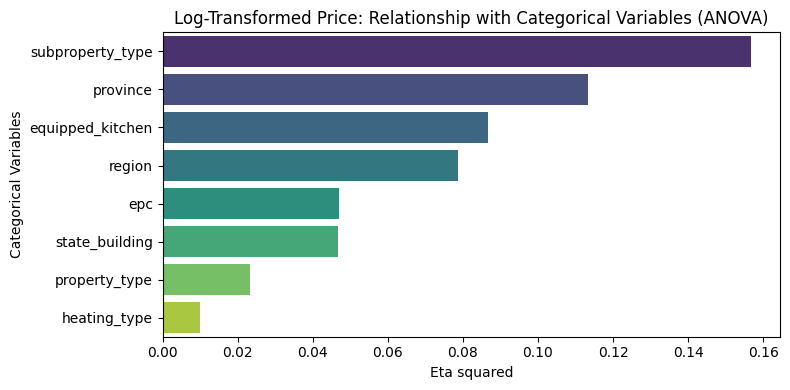

In [64]:
# Visualization of the ANOVA results

import matplotlib.pyplot as pl

plt.figure(figsize=(8, 4))
sns.barplot(data=anova_df,x="Eta_squared",y="Variable",palette="viridis")

plt.title("Log-Transformed Price: Relationship with Categorical Variables (ANOVA)")
plt.xlabel("Eta squared")
plt.ylabel("Categorical Variables")
plt.tight_layout()
plt.show()

In [66]:
# Price vs binary variables - 

# Differently from other variables we do not treat None as a separate category as binaries in this data set do not have None. That is due to preliminary cleaning. 
# For this reason we use Point-biseral correlation, which is a special case of Pearson for binary vars
from scipy.stats import pointbiserialr

binary_vars = ["fl_floodzone", "fl_double_glazing", "fl_open_fire","fl_terrace", "fl_garden", "fl_swimming_pool", "fl_furnished"]

results = []

for var in binary_vars:
    corr, p_val = pointbiserialr(df[var], df['price_log'])
    results.append({'Variable': var, 'PointBiserial_r': corr, 'p-value': p_val})

pb_df = pd.DataFrame(results).sort_values(by='PointBiserial_r', ascending=False)
print(pb_df)

            Variable  PointBiserial_r        p-value
5   fl_swimming_pool         0.173760   0.000000e+00
3         fl_terrace         0.073522   5.337691e-91
4          fl_garden         0.064347   4.204684e-70
1  fl_double_glazing         0.026274   5.169846e-13
6       fl_furnished         0.001880   6.055044e-01
2       fl_open_fire        -0.014741   5.105636e-05
0       fl_floodzone        -0.090935  2.292185e-138


In [67]:
# Inter-correlations matrix 
# price_log, zip_code, latitude, longitude excluded

import numpy as np
import pandas as pd
from scipy import stats
from math import sqrt

# Setting the variable types (epc and state_building are treated as nominal)
# Nominal categorical (multi-level)
nominal_vars = [
    "property_type", "subproperty_type", "region", "province", "locality",
    "equipped_kitchen", "heating_type",
    "epc",               # treated as nominal
    "state_building"     # treated as nominal
]

# Binary variables
binary_vars = [
    "fl_floodzone", "fl_double_glazing", "fl_open_fire",
    "fl_terrace", "fl_garden", "fl_swimming_pool", "fl_furnished"
]

# Continuous numeric
continuous_vars = ["total_area_sqm_log", "surface_land_sqm_log",
    "terrace_sqm_log", "garden_sqm_log", "primary_energy_consumption_sqm",
    "cadastral_income",
    # discrete numeric treated as continuous
    "nbr_bedrooms", "nbr_frontages", "construction_year"
]


# Effect sizes

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2, p, _, _ = stats.chi2_contingency(table, correction=False)
    n = table.sum().sum()
    r, k = table.shape
    v = sqrt(chi2 / (n * (min(k - 1, r - 1))))
    return v, p

def correlation_ratio(categories, values):
    categories = categories.astype("category")
    groups = [values[categories == cat] for cat in categories.cat.categories]
    means = np.array([g.mean() for g in groups])
    counts = np.array([g.size for g in groups])
    total_mean = np.average(values)
    ss_between = np.sum(counts * (means - total_mean)**2)
    ss_total = np.sum((values - total_mean)**2)
    eta = sqrt(ss_between / ss_total) if ss_total != 0 else 0
    f_stat, p = stats.f_oneway(*groups)
    return eta, p


def mixed_associations(df, nominal, binary, continuous):
    cols = nominal + binary + continuous # Here we take only the columns stated above not directly from the df

    n = len(cols)

    assoc = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)
    pvals = pd.DataFrame(np.ones((n, n)), index=cols, columns=cols)

    for i in range(n):
        for j in range(i, n):
            x, y = cols[i], cols[j]

            if x == y:
                assoc.loc[x,y] = 1.0
                pvals.loc[x,y] = 0.0
                continue

            # Continuous - Continuous
            if x in continuous and y in continuous:
                # Safely handling Nan without dropping the rows or replacing with 0
                subset = df[[x, y]].dropna()
                if subset.shape[0] < 2 or subset[x].nunique() <= 1 or subset[y].nunique() <= 1:
                    r, p = np.nan, np.nan
                else:
                    r, p = stats.pearsonr(subset[x], subset[y])
                assoc.loc[x,y], pvals.loc[x,y] = r, p

            # Continuous - Binary (point-biserial)
            elif (x in continuous and y in binary) or (x in binary and y in continuous):
                if x in binary:
                    bin_var, cont_var = df[x], df[y]
                else:
                    bin_var, cont_var = df[y], df[x]
                r, p = stats.pointbiserialr(bin_var, cont_var)
                assoc.loc[x,y], pvals.loc[x,y] = r, p

            # Binary - Binary (Phi coefficient)
            elif x in binary and y in binary:
                r, p = stats.pearsonr(df[x], df[y])
                assoc.loc[x,y], pvals.loc[x,y] = r, p

            # Continuous - Nominal (correlation ratio)
            elif (x in continuous and y in nominal) or (x in nominal and y in continuous):
                if x in continuous:
                    eta, p = correlation_ratio(df[y], df[x])
                else:
                    eta, p = correlation_ratio(df[x], df[y])
                assoc.loc[x,y], pvals.loc[x,y] = eta, p

            # Nominal - Nominal (Cramér’s V)
            elif x in nominal and y in nominal:
                v, p = cramers_v(df[x], df[y])
                assoc.loc[x,y], pvals.loc[x,y] = v, p

            # Binary - Nominal (Cramér’s V)
            elif (x in binary and y in nominal) or (x in nominal and y in binary):
                if x in binary:
                    v, p = cramers_v(df[x], df[y])
                else:
                    v, p = cramers_v(df[y], df[x])
                assoc.loc[x,y], pvals.loc[x,y] = v, p

            else:
                assoc.loc[x,y], pvals.loc[x,y] = np.nan, np.nan

            # mirror
            assoc.loc[y,x] = assoc.loc[x,y]
            pvals.loc[y,x] = pvals.loc[x,y]

    return assoc, pvals

#Running the analysis
assoc, pvals = mixed_associations(df, nominal_vars, binary_vars, continuous_vars)

threshold_p = 0.05
threshold_strength = 0.22 # rule of thumb for strength of relation : 0.3

strong_sig = assoc[(pvals < threshold_p) & (assoc.abs() >= threshold_strength)]

pairs = []
for i in assoc.index:
    for j in assoc.columns:
        if i < j and pvals.loc[i,j] < threshold_p and abs(assoc.loc[i,j]) >= threshold_strength:
            pairs.append((i, j, assoc.loc[i,j], pvals.loc[i,j]))

strong_pairs_df = pd.DataFrame(pairs, columns=["var1", "var2", "association", "pvalue"])

print("=== Full Association Matrix ===")
display(assoc.round(2)) 

=== Full Association Matrix ===


,property_type,subproperty_type,region,province,locality,equipped_kitchen,heating_type,epc,state_building,fl_floodzone,...,fl_furnished,total_area_sqm_log,surface_land_sqm_log,terrace_sqm_log,garden_sqm_log,primary_energy_consumption_sqm,cadastral_income,nbr_bedrooms,nbr_frontages,construction_year
property_type,1.00,1.00,0.22,0.27,0.32,0.14,0.26,0.37,0.26,0.01,...,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.54,0.00,0.00
subproperty_type,1.00,1.00,0.20,0.12,0.10,0.08,0.12,0.21,0.13,0.06,...,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.00
region,0.22,0.20,1.00,1.00,1.00,0.23,0.18,0.18,0.11,0.33,...,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00
province,0.27,0.12,1.00,1.00,1.00,0.14,0.12,0.15,0.09,0.35,...,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00
locality,0.32,0.10,1.00,1.00,1.00,0.15,0.14,0.17,0.11,0.36,...,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00
equipped_kitchen,0.14,0.08,0.23,0.14,0.15,1.00,0.14,0.17,0.19,0.11,...,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00
heating_type,0.26,0.12,0.18,0.12,0.14,0.14,1.00,0.25,0.12,0.08,...,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00
epc,0.37,0.21,0.18,0.15,0.17,0.17,0.25,1.00,0.27,0.11,...,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00
state_building,0.26,0.13,0.11,0.09,0.11,0.19,0.12,0.27,1.00,0.11,...,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00
fl_floodzone,0.01,0.06,0.33,0.35,0.36,0.11,0.08,0.11,0.11,1.00,...,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,-0.02,NaN,NaN


In [68]:
# Inter-correlations matrix - single out strong and significant correlations
pairs = []
for i in assoc.index:
    for j in assoc.columns:
        if i < j and pvals.loc[i,j] < threshold_p and abs(assoc.loc[i,j]) >= threshold_strength:
            pairs.append((i, j, assoc.loc[i,j], pvals.loc[i,j]))

strong_pairs_df = pd.DataFrame(pairs, columns=["var1", "var2", "association", "pvalue"])
print("=== Significant & Strong Associations (pairwise table) ===")
display(strong_pairs_df.sort_values(by="association", key=lambda x: x.abs(), ascending=False))

=== Significant & Strong Associations (pairwise table) ===


,var1,var2,association,pvalue
4,province,region,1.000000,0.0
6,locality,region,1.000000,0.0
7,locality,province,1.000000,0.0
0,property_type,subproperty_type,1.000000,0.0
30,nbr_bedrooms,total_area_sqm_log,0.745861,0.0
29,nbr_bedrooms,subproperty_type,0.601790,0.0
28,nbr_bedrooms,property_type,0.537008,0.0
32,nbr_frontages,surface_land_sqm_log,0.440129,0.0
13,epc,property_type,0.372504,0.0
18,fl_floodzone,locality,0.363847,0.0


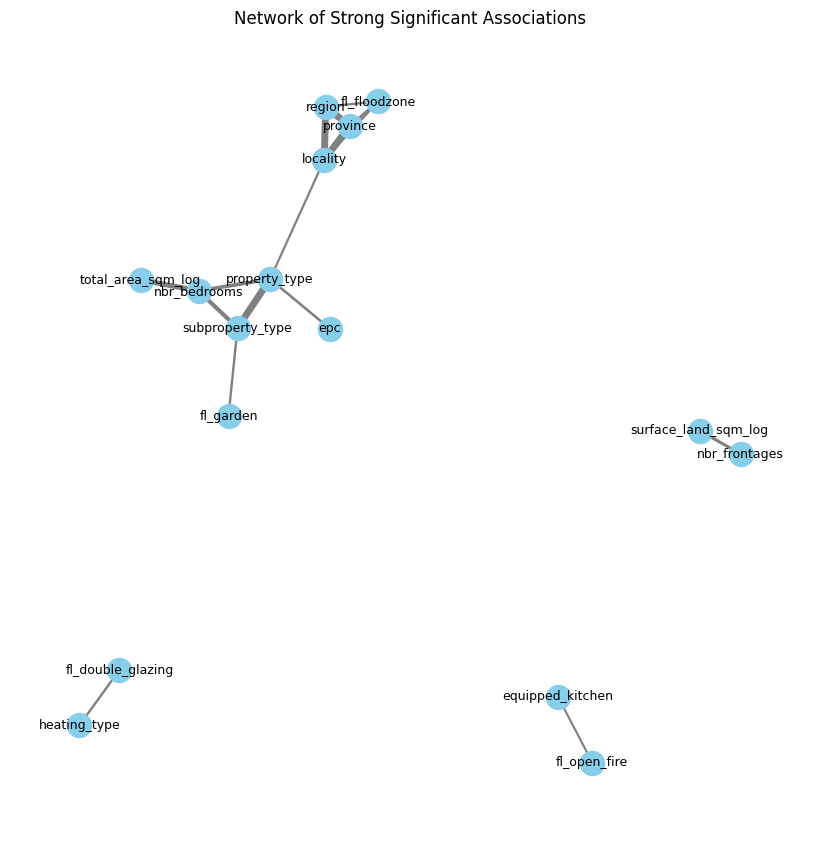

In [69]:
# Inter-correlations matrix - visualizaiton
import networkx as nx

# Build graph
G = nx.Graph()
for i in assoc.index:
    for j in assoc.columns:
        if i < j and pvals.loc[i,j] < 0.05 and abs(assoc.loc[i,j]) >= 0.3:
            G.add_edge(i, j, weight=assoc.loc[i,j])

# Draw
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=0.5, iterations=110, seed=52)
edges = G.edges(data=True)
weights = [abs(d['weight'])*5 for (u,v,d) in edges]  # scale width
nx.draw(G, pos, with_labels=True, font_size=9, width=weights, node_color='skyblue', edge_color='grey')
plt.title("Network of Strong Significant Associations")
plt.show()

In [ ]:
# Correlations within meaningful subgroups: What predicts price within each region, within each province, within each subproperty type?

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency, f_oneway
from math import sqrt

num_vars = ['total_area_sqm_log','surface_land_sqm_log','terrace_sqm_log','garden_sqm_log','nbr_bedrooms','construction_year','primary_energy_consumption_sqm','nbr_frontages','cadastral_income']
bin_vars = [c for c in df.columns if c.startswith("fl_")]
nominal_vars = ['property_type','subproperty_type','region','province','epc','heating_type','equipped_kitchen','state_building','locality']

def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.size == 0:
        return np.nan, np.nan
    chi2, p, _, _ = chi2_contingency(tbl, correction=False)
    n = tbl.values.sum()
    r, k = tbl.shape
    v = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
    return v, p

def eta_squared_anova(cat, y):
    df_nonan = pd.DataFrame({ "cat": cat, "y": y }).dropna()
    if df_nonan["cat"].nunique() < 2:
        return np.nan, np.nan
    groups = [df_nonan["y"][df_nonan["cat"] == c] for c in df_nonan["cat"].unique()]
    f_stat, p = f_oneway(*groups)
    #Eta squared
    grand_mean = df_nonan["y"].mean()
    ss_between = sum([len(g)*(g.mean()-grand_mean)**2 for g in groups])
    ss_total = sum((df_nonan["y"] - grand_mean)**2)
    eta2 = ss_between/ss_total if ss_total != 0 else np.nan
    return eta2, p

def full_within_group_associations(df, group_col, num_vars, bin_vars, nominal_vars):
    results = []
    groups = df[group_col].dropna().unique()

    for g in groups:
        subdf = df[df[group_col] == g] # For each group(e.g. Flanders in region, it creates a small df that contains only rows belonging to is)

        # NUMERIC predictors - Pearson's
        for var in num_vars:
            x = subdf['price_log']
            y = subdf[var]
            valid = x.notna() & y.notna()
            if valid.sum() > 2:
                r, p = pearsonr(x[valid], y[valid])
            else:
                r, p = np.nan, np.nan
            results.append({
                "Group_var": group_col,
                "Group": g,
                "Variable": var,
                "Type": "numeric",
                "Association": r,
                "p_value": p,
                "Test": "Pearson r",
                "N": valid.sum()
            })

        # BINARY predictors - Point biserial
        for var in bin_vars:
            x = subdf['price_log']
            y = subdf[var]
            valid = x.notna() & y.notna()
            if valid.sum() > 2 and y.dropna().nunique() > 1:
                r, p = pointbiserialr(y[valid], x[valid])
            else:
                r, p = np.nan, np.nan
            results.append({
                "Group_var": group_col,
                "Group": g,
                "Variable": var,
                "Type": "binary",
                "Association": r,
                "p_value": p,
                "Test": "Point-biserial r",
                "N": valid.sum()
            })

        # NOMINAL predictors -  ANOVA + eta²
        for var in nominal_vars:
            eta2, p = eta_squared_anova(subdf[var], subdf['price_log'])
            results.append({
                "Group_var": group_col,
                "Group": g,
                "Variable": var,
                "Type": "nominal",
                "Association": eta2,
                "p_value": p,
                "Test": "Eta² (ANOVA)",
                "N": subdf[var].notna().sum()
            })

    return pd.DataFrame(results)

# Running for region
res_region = full_within_group_associations(df, "region", num_vars, bin_vars, nominal_vars)

# Running for province 
res_province = full_within_group_associations(df, "province", num_vars, bin_vars, nominal_vars)

# Running for subtype property

res_subtype = full_within_group_associations(df, "subproperty_type", num_vars, bin_vars, nominal_vars)

def prepare_summary_table(df_results):
    df_summary = df_results.rename(columns={
        "Group": "group",
        "Variable": "var2",
        "Association": "assoc",
        "p_value": "pvalue",
        "Test": "test_type"
    })
    df_summary["test_type"] = df_summary["test_type"].str.lower()
    df_summary["test_type"] = df_summary["test_type"].replace({
    "pearson r": "pearson",
    "point-biserial r": "point_biserial",
    "eta² (anova)": "anova_eta",
    "cramers v": "cramers_v"
    })
    df_summary["var1"] = "price_log"
    return df_summary

df_region_summary = prepare_summary_table(res_region)
df_province_summary = prepare_summary_table(res_province)
df_subtype_summary = prepare_summary_table(res_subtype)



In [ ]:
# Interpretation of effects

def interpret_effect(test_type, assoc):
    a = abs(assoc)

    if test_type in ["pearson", "spearman", "point_biserial"]:
        if a > 0.50: return "very strong"
        if a > 0.30: return "strong"
        if a > 0.15: return "moderate"
        if a > 0.05: return "weak"
        return "very weak"

    if test_type == "anova_eta":
        if a > 0.26: return "very large"
        if a > 0.14: return "large"
        if a > 0.06: return "medium"
        if a > 0.01: return "small"
        return "very small"

    if test_type == "cramers_v":
        if a > 0.50: return "very strong"
        if a > 0.30: return "strong"
        if a > 0.20: return "moderate"
        if a > 0.10: return "weak"
        return "very weak"

    # fallback
    return "effect"

def summarize_group_correlations(df_results, top_n=5):
    summaries = {}
    for g in df_results["group"].unique():
        sub = df_results[(df_results["group"] == g) & (df_results["pvalue"] < 0.05)]
        sub = sub.reindex(sub["assoc"].abs().sort_values(ascending=False).index)

        top = sub.head(top_n)

        insights = []
        for _, row in top.iterrows():
            var = row["var2"]
            test = row["test_type"]
            assoc = row["assoc"]
            direction = "positive" if assoc > 0 else "negative"

            strength = interpret_effect(test, assoc)

            insights.append(f"• {var}: {strength} ({direction}), from {test}")

        summaries[g] = insights

    return summaries

summary_region = summarize_group_correlations(df_region_summary, top_n=5)
summary_province = summarize_group_correlations(df_province_summary, top_n=5)
summary_subtype = summarize_group_correlations(df_subtype_summary, top_n=5)


print("=== REGION ===")
for region, insights in summary_region.items():
    print(f"\n--- {region} ---")
    for item in insights:
        print(item)

print("\n=== PROVINCE ===")
for province, insights in summary_province.items():
    print(f"\n--- {province} ---")
    for item in insights:
        print(item)

print("\n=== SUBPROPERTY TYPE ===")
for subtype, insights in summary_subtype.items():
    print(f"\n--- {subtype} ---")
    for item in insights:
        print(item)



# Interpretation of results
# At level regions:
#
#   Flanders: Total area and bedrooms dominate. Land size matters moderately; 
#   subproperty type has a large effect;
#   Terrace and garden have smaller effects.
#   
#   Brussels-Capital: Total area, bedrooms, and subproperty type dominate (very strong/very large). 
#   Terrace and surface land are strong predictors. This makes sense because properties are smaller and more heterogeneous; 
#   subproperty type captures structural differences.
#
#   Wallonia: Again, total area dominates, bedrooms and frontages are important. 
#   Land is stronger here than in Brussels, terrace is moderately important. 
#   This reflects larger plots and more detached houses.
#
# Overall message: The importance of variables shifts with region: total area is universally critical, 
# but land size becomes more meaningful in Wallonia; subproperty type dominates in dense regions like Brussels.
#
# At level province:
#
#   Antwerp, East Flanders, Brussels: Total area and bedrooms remain dominant; cadastral income appears in strong predictors in some provinces, signaling urban-specific effects.
#
#   Walloon Brabant & Flemish Brabant: Cadastral income becomes very strong;
#   total area still dominates, highlighting wealth and valuation differences.
#   
#   Hainaut & Liège: Swimming pool presence starts appearing as moderate predictor—amenities matter more in less dense areas.
#   
# Overall message: Province-level analysis reveals subregional variations. Some features like cadastral income, land, and amenities are more predictive in specific provinces.
#   
#
#At level sub-property type:
#
#Subproperty-type insights
#   Detached houses, villas, farmhouses: Land area, total area, and bedrooms dominate; province and region also important (geography matters).
#   
#   Apartments, studios, flats: Terrace, construction year, and locality are stronger; land is less relevant. Subproperty type captures a lot of variance here.
#   
#   Luxury/exclusive properties (mansions, castles, triplex, chalet): Total area, cadastral income, and locality dominate; state of the building is also important.
#
# Overall message: Price drivers shift heavily by property type: for apartments, vertical space and amenities matter more;
# for detached and luxury houses, total plot and cadastral income dominate.
#

=== REGION ===

--- Flanders ---
• total_area_sqm_log: very strong (positive), from pearson
• nbr_bedrooms: strong (positive), from pearson
• nbr_frontages: moderate (positive), from pearson
• surface_land_sqm_log: moderate (positive), from pearson
• subproperty_type: large (positive), from anova_eta

--- Brussels-Capital ---
• total_area_sqm_log: very strong (positive), from pearson
• nbr_bedrooms: very strong (positive), from pearson
• subproperty_type: very large (positive), from anova_eta
• terrace_sqm_log: strong (positive), from pearson
• surface_land_sqm_log: strong (positive), from pearson

--- Wallonia ---
• total_area_sqm_log: very strong (positive), from pearson
• nbr_bedrooms: strong (positive), from pearson
• nbr_frontages: strong (positive), from pearson
• surface_land_sqm_log: strong (positive), from pearson
• terrace_sqm_log: moderate (positive), from pearson

=== PROVINCE ===

--- Antwerp ---
• total_area_sqm_log: very strong (positive), from pearson
• nbr_bedrooms: ve

In [31]:
# Visualization of the Pearson's and Pointbiserial results

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

categories = ["total_area_sqm_log","nbr_bedrooms","surface_land_sqm_log","nbr_frontages","fl_swimming_pool"]

values = [
    0.592684,   # strong
    0.434120,   # moderate
    0.257446,   # small
    0.234163,   # small
    0.173760    # small
]

# Assigning colors 
def color_for_value(v):
    if v >= 0.5:
        return "#003300"      # strong
    elif v >= 0.3:
        return "forestgreen"    # moderate
    else:
        return "lightgreen"     # small

colors = [color_for_value(v) for v in values]

# Bar plot
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=categories,
        y=values,
        marker=dict(color=colors),
        name="",
        width=0.6,
        showlegend=False
    )
)

# Add fake (legend-only) traces to show thresholds
fig.add_trace(go.Bar(x=[None], y=[None], marker_color="lightgreen", name="Small (< 0.3)"))
fig.add_trace(go.Bar(x=[None], y=[None], marker_color="forestgreen", name="Moderate (0.3–0.5)"))
fig.add_trace(go.Bar(x=[None], y=[None], marker_color="darkgreen", name="Strong (≥ 0.5)"))

fig.update_layout(
    title=dict(text="Correlation Strengths (Point-Biserial / Pearson)", font=dict(size=22)),
    xaxis=dict(
        title="Numerical variable",
        title_font=dict(size=22),
        tickfont=dict(size=16)  # category labels
    ),
    yaxis=dict(
        title="Correlation Coefficient",
        title_font=dict(size=22),
        tickfont=dict(size=16)
    ),
    legend=dict(
        title="",
        font=dict(size=16)
    ),
    template="plotly_white",
    bargap=0.35  # space between bars
)

fig.show()

In [35]:
# Visualization of the ANOVA results

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

variables = ["subproperty_type","province","equipped_kitchen","region","epc","state_building","property_type"]

eta_sq = [0.156623,0.113300,0.086611,0.078650,0.047030,0.046850,0.023201]

def color_for_eta(v):
    if v >= 0.14:
        return "#003300"        # large
    elif v >= 0.06:
        return "forestgreen"      # medium
    elif v >= 0.01:
        return "lightgreen"       # small
    else:
        return "lightgray"        # very small

colors = [color_for_eta(v) for v in eta_sq]

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=variables,
        y=eta_sq,
        marker=dict(color=colors),
        width=0.6,
        name="",
        showlegend=False
    )
)

# Legend-only traces (same trick as before)
fig.add_trace(go.Bar(x=[None], y=[None], marker_color="lightgreen",  name="Small (η² < 0.06)"))
fig.add_trace(go.Bar(x=[None], y=[None], marker_color="forestgreen", name="Medium (0.06 ≤ η² < 0.14)"))
fig.add_trace(go.Bar(x=[None], y=[None], marker_color="darkgreen",   name="Large (η² ≥ 0.14)"))


fig.update_layout(
    title=dict(text="ANOVA Effect Sizes (Eta-Squared)", font=dict(size=22)),
    xaxis=dict(
        title="Categorical Variable",
        title_font=dict(size=20),
        tickfont=dict(size=16)
    ),
    yaxis=dict(
        title="η²",
        title_font=dict(size=20),
        tickfont=dict(size=16)
    ),
    legend=dict(
        title="Effect Size Categories",
        font=dict(size=16)
    ),
    template="plotly_white",
    bargap=0.35
)

fig.show()

